import libraries / modules

In [285]:
import pandas as pd
import geopandas as gpd
import lightgbm as lgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer
)
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

load & prepare data

In [3]:
faults_raw = pd.read_csv("../data/J1939Faults.csv", dtype={"EquipmentID": str, 'spn':int})
diagnostics_raw = pd.read_csv("../data/vehiclediagnosticonboarddata.csv")
display(faults_raw.head())
display(diagnostics_raw.head())

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
0,1,990349,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25.000
1,2,990360,2015-02-21 11:34:34.000,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10.000
2,3,990364,2015-02-21 11:35:31.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,False,127,NaN,1369,105336226,41.421250,-87.767361,2015-02-21 11:35:26.000
3,4,990370,2015-02-21 11:35:33.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,True,127,NaN,1369,105336226,41.421018,-87.767361,2015-02-21 11:36:08.000
4,5,990416,2015-02-21 11:39:41.000,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,17,False,2,NaN,1674,105427130,38.416481,-89.442638,2015-02-21 11:39:37.000


,Id,Name,Value,FaultId
0,1,IgnStatus,False,1
1,2,EngineOilPressure,0,1
2,3,EngineOilTemperature,96.74375,1
3,4,TurboBoostPressure,0,1
4,5,EngineLoad,11,1


In [9]:
faults_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187335 entries, 0 to 1187334
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   RecordID               1187335 non-null  int64  
 1   ESS_Id                 1187335 non-null  int64  
 2   EventTimeStamp         1187335 non-null  object 
 3   eventDescription       1126490 non-null  object 
 4   actionDescription      0 non-null        float64
 5   ecuSoftwareVersion     891285 non-null   object 
 6   ecuSerialNumber        844318 non-null   object 
 7   ecuModel               1122577 non-null  object 
 8   ecuMake                1122577 non-null  object 
 9   ecuSource              1187335 non-null  int64  
 10  spn                    1187335 non-null  int32  
 11  fmi                    1187335 non-null  int64  
 12  active                 1187335 non-null  bool   
 13  activeTransitionCount  1187335 non-null  int64  
 14  faultValue        

In [13]:
diagnostics_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12821626 entries, 0 to 12821625
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   Id       int64 
 1   Name     object
 2   Value    object
 3   FaultId  int64 
dtypes: int64(2), object(2)
memory usage: 391.3+ MB


In [15]:
faults_raw['EventTimeStamp'] = pd.to_datetime(faults_raw['EventTimeStamp'])

In [17]:
# prepare faults
faults_drop_cols = ["actionDescription", "activeTransitionCount", "eventDescription", "ecuSource", "ecuSoftwareVersion", "ecuModel", "ecuMake", "faultValue", "MCTNumber", "LocationTimeStamp"]
faults = faults_raw.drop(columns=faults_drop_cols)
print("\n\n--------FAULTS_RAW COLUMNS--------")
display(faults.columns)
print("\n\n--------SHAPE OF FAULTS--------")
display(faults.shape)
print("\n\n--------NaNs--------")
display(faults.isna().sum())



--------FAULTS_RAW COLUMNS--------


Index(['RecordID', 'ESS_Id', 'EventTimeStamp', 'ecuSerialNumber', 'spn', 'fmi',
       'active', 'EquipmentID', 'Latitude', 'Longitude'],
      dtype='object')



--------SHAPE OF FAULTS--------


(1187335, 10)



--------NaNs--------


RecordID                0
ESS_Id                  0
EventTimeStamp          0
ecuSerialNumber    343017
spn                     0
fmi                     0
active                  0
EquipmentID             0
Latitude                0
Longitude               0
dtype: int64

In [19]:
# join diagnostics
print("--------NaNs--------")
print(diagnostics_raw.isna().sum())
n_ids = len(diagnostics_raw['Id'])
n_unique_id = diagnostics_raw['Id'].nunique()
n_un_faults = diagnostics_raw['FaultId'].nunique()

diagnostics_raw["Value"] = diagnostics_raw["Value"].replace(
    {"FALSE": False, "TRUE": True}
)

# pivot diagnostics to long format
diagnostics = diagnostics_raw.pivot(
    index="FaultId", columns="Name", values="Value"
)

print(f"\nlen(Id): {n_ids}", f"\nN unique_Id: {n_unique_id}")
print("\n--------RECORD ID vs FAULT ID--------")
print(f"n_unique FaultID: {n_un_faults}", f"\nn_unique RecordID: {faults['RecordID'].nunique()}")
joined = faults.merge(diagnostics, how = "inner", left_on='RecordID', right_on='FaultId')
print("\n\n--------JOINED--------")
display(joined.head())
print("\n\n--------JOINED COLUMNS---------")
print(joined.columns)


--------NaNs--------
Id         0
Name       0
Value      0
FaultId    0
dtype: int64

len(Id): 12821626 
N unique_Id: 12821626

--------RECORD ID vs FAULT ID--------
n_unique FaultID: 1187335 
n_unique RecordID: 1187335


--------JOINED--------


,RecordID,ESS_Id,EventTimeStamp,ecuSerialNumber,spn,fmi,active,EquipmentID,Latitude,Longitude,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
0,1,990349,2015-02-21 10:47:13,unknown,111,17,True,1439,38.857638,-84.626851,...,NaN,False,78.8,1023,True,NaN,0,3276.75,NaN,0
1,2,990360,2015-02-21 11:34:34,unknown,629,12,True,1439,38.857638,-84.626851,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
2,3,990364,2015-02-21 11:35:31,unknown,1807,2,False,1369,41.421250,-87.767361,...,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
3,4,990370,2015-02-21 11:35:33,unknown,1807,2,True,1369,41.421018,-87.767361,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
4,5,990416,2015-02-21 11:39:41,13063430,4364,17,False,1674,38.416481,-89.442638,...,NaN,NaN,NaN,16639,NaN,NaN,NaN,NaN,NaN,NaN




--------JOINED COLUMNS---------
Index(['RecordID', 'ESS_Id', 'EventTimeStamp', 'ecuSerialNumber', 'spn', 'fmi',
       'active', 'EquipmentID', 'Latitude', 'Longitude', 'AcceleratorPedal',
       'BarometricPressure', 'CruiseControlActive', 'CruiseControlSetSpeed',
       'DistanceLtd', 'EngineCoolantTemperature', 'EngineLoad',
       'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm',
       'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature',
       'IgnStatus', 'IntakeManifoldTemperature', 'LampStatus', 'ParkingBrake',
       'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle',
       'TurboBoostPressure'],
      dtype='object')


filter out faults near service stations

In [21]:
# filter out near service stations
joined_pre_station_filter = joined
print("Labeling faults near service stations...")
stations = pd.DataFrame(
    {
        "lat": [36.0666667, 35.5883333, 36.1950],
        "lon": [-86.4347222, -86.4438888, -83.174722],
    }
)
threshold_miles = 0.5
threshold_meters = threshold_miles * 1609.34
# create geodataframes with geopandas
gdf_joined = gpd.GeoDataFrame(
    joined,
    geometry=gpd.points_from_xy(joined.Latitude, joined.Longitude),
    crs="EPSG:4326",  # WGS84 coord ref sys (lat/lon)
)
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations.lat, stations.lon),
    crs="EPSG:4326",
)
target_crs = "EPSG:9311"
# reproject onto new crs for better distance measurement
gdf_joined_proj = gdf_joined.to_crs(target_crs)
gdf_stations_proj = gdf_stations.to_crs(target_crs)
# create buffers around stations
station_buf = gdf_stations_proj.geometry.buffer(threshold_meters)
combined_buffer = (
    station_buf.union_all()
)  # turns into single geometry which helps with efficiency
is_within = gdf_joined_proj.geometry.within(combined_buffer)
joined["nearStation"] = is_within.values
joined_post_filter = joined[~joined["nearStation"]]
print("\nDone! \nFaults within 1km of service station labeled in 'joined'.")
print(
    f"When filtered, this removes {len(joined_pre_station_filter['RecordID']) - len(joined_post_filter['RecordID'])} rows"
)
# filter out active=False
joined_active = joined[joined["active"]]
print(
    f"\nNumber of rows after filtering active=False out: {len(joined_active['active'])}"
)
print(
    f"Rows removed: {len(joined_pre_station_filter['RecordID']) - len(joined_active['active'])}"
)



Labeling faults near service stations...

Done! 
Faults within 1km of service station labeled in 'joined'.
When filtered, this removes 129284 rows

Number of rows after filtering active=False out: 608454
Rows removed: 578881


In [ ]:
print(joined.columns)

In [23]:
joined_ns = joined[joined['nearStation'] == False]

In [ ]:
derates_2019 = joined_ns[(joined_ns['spn'] == 5246) & (joined_ns['EventTimeStamp'] > '12-31-2018') & (joined_ns['active'] == True)].copy()
derates_2019['derate_gap'] = derates_2019.sort_values(by=['EquipmentID', 'EventTimeStamp']).groupby('EquipmentID')['EventTimeStamp'].diff()
gap = pd.to_timedelta("24 hours")
confirmed_derates_2019 = derates_2019[(derates_2019.derate_gap.isnull()) | (derates_2019['derate_gap'] > gap)]

In [25]:
joined_ns.shape

(1058051, 35)

In [27]:
joined_ns[joined_ns['active'] == True].shape

(549008, 35)

In [ ]:
joined_ns.columns

In [29]:
joined_ns = joined_ns.drop(columns = ['ESS_Id'
                                      , 'ecuSerialNumber'
                                      , 'AcceleratorPedal'
                                      , 'CruiseControlActive'
                                      , 'CruiseControlSetSpeed'
                                      , 'IgnStatus'
                                      , 'ParkingBrake'
                                      , 'ServiceDistance'
                                      , 'nearStation'])

In [31]:
cols = ['BarometricPressure', 'DistanceLtd',
       'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure',
       'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel',
       'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature', 
        'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure']
joined_ns[cols] = joined_ns[cols].apply(pd.to_numeric, errors='coerce', axis=1)


In [35]:
joined_ns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1058051 entries, 0 to 1187334
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   RecordID                   1058051 non-null  int64         
 1   EventTimeStamp             1058051 non-null  datetime64[ns]
 2   spn                        1058051 non-null  int32         
 3   fmi                        1058051 non-null  int64         
 4   active                     1058051 non-null  bool          
 5   EquipmentID                1058051 non-null  object        
 6   Latitude                   1058051 non-null  float64       
 7   Longitude                  1058051 non-null  float64       
 8   BarometricPressure         531267 non-null   float64       
 9   DistanceLtd                531128 non-null   float64       
 10  EngineCoolantTemperature   531261 non-null   float64       
 11  EngineLoad                 530810 non-null

to impute:
BarometricPressure = mean
DistanceLtd = mean (should group by truck, tho)
EngineCoolantTemperature 
EngineLoad
EngineOilPressure
EngineOilTemperature
EngineRpm
EngineTimeLtd
FuelLevel
FuelLtd
FuelRate
FuelTemperature
IntakeManifoldTemperature
Speed
SwitchedBatteryVoltage
Throttle
TurboBoostPressure

In [37]:
full_derates_raw = joined_ns[joined_ns['spn'] == 5246]
partial_derates_raw = joined_ns[(joined_ns['spn'] == 1569) & (joined_ns['fmi'] == 31)]
# print("--------FULL DERATES---------")
# display(f"derate shape: {full_derates_raw.shape}", full_derates_raw.head(3))
#print("\n--------PARTIAL DERATES---------")
#display(f"partial derate shape: {partial_derates_raw.shape}", partial_derates_raw.head(3))

- [x] look at time series by Equipment ID

In [734]:
col_order = [
    "RecordID",
    "EquipmentID",
    "EventTimeStamp",
    "spn",
    "fmi",
    "active",
    "Latitude",
    "Longitude",
    "BarometricPressure",
    "DistanceLtd",
    "EngineCoolantTemperature",
    "EngineLoad",
    "EngineOilPressure",
    "EngineOilTemperature",
    "EngineRpm",
    "EngineTimeLtd",
    "FuelLevel",
    "FuelLtd",
    "FuelRate",
    "FuelTemperature",
    "IntakeManifoldTemperature",
    "LampStatus",
    "Speed",
    "SwitchedBatteryVoltage",
    "Throttle",
    "TurboBoostPressure"
]
target_spn = 5246

# --- SORTING STEP ---
# Sort by EquipmentID and then chronologically by EventTimeStamp
print("Sorting data by EquipmentID and EventTimeStamp...")
joined_ns = joined_ns.sort_values(by=["EquipmentID", "EventTimeStamp"]).copy()
print("Sorting complete.")

# Create a Series containing only the timestamps of trigger events
trigger_timestamps_only = joined_ns["EventTimeStamp"].where(joined_ns["spn"] == target_spn)

# For each row, find the timestamp of the *next* trigger event within its group
# Group by EquipmentID and use backward fill (bfill)
# This fills NaT values with the next valid timestamp in the group
print("Calculating next trigger time...")
joined_ns["next_trigger_time"] = trigger_timestamps_only.groupby(
    joined_ns["EquipmentID"]
).bfill()

# Calculate the start of the 2-hour window before the next trigger
joined_ns["window_start_time"] = joined_ns["next_trigger_time"] - pd.Timedelta(hours=6)

# Label rows as True if their timestamp falls within the window:
#    [window_start_time, next_trigger_time]
#    Also ensure that a next_trigger_time actually exists (it's not NaT)
print("Labeling derate window...")
joined_ns["derate_window"] = (
    (joined_ns["EventTimeStamp"] >= joined_ns["window_start_time"])
    & (joined_ns["EventTimeStamp"] <= joined_ns["next_trigger_time"])
    & (joined_ns["next_trigger_time"].notna())
)

# Optional: Reorder columns if desired (ensure 'derate_window' is in col_order)
# joined = joined[col_order]

# --- Verification ---
print("\nVerification:")
print(
    "Value counts for 'derate_window':\n",
    joined_ns["derate_window"].value_counts(),
)
print(
    "\nValue counts for 'spn' (to confirm target SPN exists):\n",
    joined_ns["spn"].value_counts(),
)

# Display some rows where derate_window is True (if any)
print("\nSample rows where derate_window is True:")
print(
    joined_ns[joined_ns["derate_window"]][
        ["EquipmentID", "EventTimeStamp", "spn", "next_trigger_time"]
    ].head()
)

# Display some rows around a trigger event for a specific EquipmentID
# Find an EquipmentID that has a trigger event
example_eqid = joined_ns.loc[joined_ns["spn"] == target_spn, "EquipmentID"].iloc[0]
print(f"\nSample data around trigger for EquipmentID: {example_eqid}")
example_trigger_time = joined_ns.loc[
    (joined_ns["EquipmentID"] == example_eqid) & (joined_ns["spn"] == target_spn),
    "EventTimeStamp",
].min()
# Filter data around that time for that equipment
print(
    joined_ns[
        (joined_ns["EquipmentID"] == example_eqid)
        & (joined_ns["EventTimeStamp"] >= (example_trigger_time - pd.Timedelta(hours=3)))
        & (joined_ns["EventTimeStamp"] <= (example_trigger_time + pd.Timedelta(hours=1)))
    ][
        [
            "EquipmentID",
            "EventTimeStamp",
            "spn",
            "next_trigger_time",
            "window_start_time",
            "derate_window",
        ]
    ]
)

# Optional: Drop helper columns if no longer needed
# joined = joined.drop(columns=['next_trigger_time', 'window_start_time'])


Sorting data by EquipmentID and EventTimeStamp...
Sorting complete.
Calculating next trigger time...
Labeling derate window...

Verification:
Value counts for 'derate_window':
 derate_window
False    1054737
True        3314
Name: count, dtype: int64

Value counts for 'spn' (to confirm target SPN exists):
 spn
111      345567
929      228321
96        82614
829       82090
639       32136
          ...  
904           1
65287         1
46262         1
54478         1
37265         1
Name: count, Length: 422, dtype: int64

Sample rows where derate_window is True:
       EquipmentID      EventTimeStamp   spn   next_trigger_time
996737   105349576 2018-07-06 03:53:05  3031 2018-07-06 09:42:48
996738   105349576 2018-07-06 03:53:05  1761 2018-07-06 09:42:48
996739   105349576 2018-07-06 03:53:05  1761 2018-07-06 09:42:48
996740   105349576 2018-07-06 03:53:06  3364 2018-07-06 09:42:48
996749   105349576 2018-07-06 04:53:05  1569 2018-07-06 09:42:48

Sample data around trigger for Equipment

In [736]:
joined_ns = joined_ns.drop(columns = ['next_trigger_time', 'window_start_time'])
joined_ns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1058051 entries, 1001106 to 4999
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   RecordID                   1058051 non-null  int64         
 1   EventTimeStamp             1058051 non-null  datetime64[ns]
 2   spn                        1058051 non-null  int32         
 3   fmi                        1058051 non-null  int64         
 4   active                     1058051 non-null  bool          
 5   EquipmentID                1058051 non-null  object        
 6   Latitude                   1058051 non-null  float64       
 7   Longitude                  1058051 non-null  float64       
 8   BarometricPressure         531267 non-null   float64       
 9   DistanceLtd                531128 non-null   float64       
 10  EngineCoolantTemperature   531261 non-null   float64       
 11  EngineLoad                 530810 non-n

In [954]:
joined_ns_act = joined_ns[joined_ns['active'] == True]
joined_ns_act = joined_ns_act.drop(columns = ['active', 'LampStatus'])
#joined_ns_act['EquipmentID'] = joined_ns_act['EquipmentID'].apply(pd.to_numeric, errors='coerce')

In [956]:
joined_ns_act['derate'] = np.where(joined_ns_act['derate_window'] == True, 1, 0)
joined_ns_act['derate'] = joined_ns_act['derate'].shift(-1)
joined_ns_act = joined_ns_act[:-1]

#joined_ns_act.shape

In [958]:
joined_ns_act['derate'] = np.where((joined_ns_act['derate'] == 1) | (joined_ns_act['spn'] == 5246), 1, 0)

In [742]:
joined_ns_act

,RecordID,EventTimeStamp,spn,fmi,EquipmentID,Latitude,Longitude,BarometricPressure,DistanceLtd,EngineCoolantTemperature,...,FuelLtd,FuelRate,FuelTemperature,IntakeManifoldTemperature,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,derate_window,derate
1001106,1038243,2018-07-20 09:31:33,1231,16,0105406655,36.139351,-85.629722,14.1375,91442.550,181.4,...,12311.606397,1.651080,NaN,138.2,5.203984,NaN,100.0,5.80,False,0
358800,366301,2016-01-31 07:12:25,629,12,105301976,41.987175,-87.731990,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
927313,955890,2018-01-26 18:58:08,37,18,105338729,38.348564,-85.709120,14.5725,1435.370,170.6,...,199.053641,0.647223,NaN,120.2,0.000000,NaN,100.0,0.29,False,0
936445,965022,2018-02-12 20:29:39,5939,16,105338729,39.953425,-81.935462,14.5000,6107.708,179.6,...,843.897620,1.492577,NaN,114.8,0.000000,NaN,100.0,1.16,False,0
936451,965028,2018-02-12 20:33:23,5939,0,105338729,39.953379,-81.935416,14.5000,6107.712,179.6,...,843.897620,1.201987,NaN,109.4,0.281559,NaN,100.0,0.29,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157136,1214360,2019-11-12 00:24:39,639,2,310,35.271666,-86.397361,14.3550,327738.300,185.0,...,44386.056091,2.166218,NaN,102.2,4.466105,NaN,100.0,2.61,False,0
4245,4246,2015-02-24 13:45:06,1761,17,R1762,41.254166,-85.088888,14.0650,79796.120,185.0,...,11368.512172,14.727640,32.0,82.4,65.962430,3276.75,47.2,16.82,False,0
4427,4428,2015-02-24 15:31:17,1761,18,R1762,39.944444,-86.016990,14.1375,79913.240,179.6,...,11390.042194,9.166799,32.0,82.4,66.836240,3276.75,67.2,8.99,False,0
6438,6439,2015-02-26 13:12:11,5848,9,R1762,39.952870,-81.936990,14.2100,80838.700,134.6,...,11527.675833,0.660432,32.0,84.2,2.058292,3276.75,0.0,0.29,False,0


In [744]:
joined_ns_act.info()

<class 'pandas.core.frame.DataFrame'>
Index: 549008 entries, 1001106 to 4952
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   RecordID                   549008 non-null  int64         
 1   EventTimeStamp             549008 non-null  datetime64[ns]
 2   spn                        549008 non-null  int32         
 3   fmi                        549008 non-null  int64         
 4   EquipmentID                549008 non-null  object        
 5   Latitude                   549008 non-null  float64       
 6   Longitude                  549008 non-null  float64       
 7   BarometricPressure         531267 non-null  float64       
 8   DistanceLtd                531128 non-null  float64       
 9   EngineCoolantTemperature   531261 non-null  float64       
 10  EngineLoad                 530810 non-null  float64       
 11  EngineOilPressure          531373 non-null  float64  

In [714]:
joined_ns_act.fillna(method='ffill', inplace=True)
joined_ns_act.fillna(method='bfill', inplace=True)

C:\Users\Maria\AppData\Local\Temp\ipykernel_36188\3993402840.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  joined_ns_act.fillna(method='ffill', inplace=True)
C:\Users\Maria\AppData\Local\Temp\ipykernel_36188\3993402840.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  joined_ns_act.fillna(method='bfill', inplace=True)


In [960]:
joined_ns_act['IsTestData'] = joined_ns_act['EventTimeStamp'] >= '2019-01-01'
train_data = joined_ns_act[joined_ns_act['IsTestData'] == False]
test_data = joined_ns_act[joined_ns_act['IsTestData'] == True]

In [962]:
random_state = 321

X_train = train_data.drop(columns = ['RecordID', 'EventTimeStamp', #'fmi', 
                                     'EquipmentID', 'derate_window',
                                     'derate', 'IsTestData'])
y_train = train_data['derate']
X_test = test_data.drop(columns = ['RecordID', 'EventTimeStamp', #'fmi', 
                                   'EquipmentID', 'derate_window',
                                   'derate', 'IsTestData'])
y_test = test_data['derate']

In [964]:
si = SimpleImputer().fit(X_train)

X_train = si.transform(X_train)
X_test = si.transform(X_test)

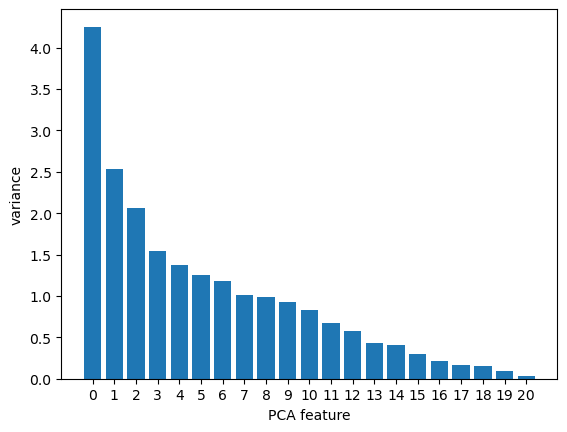

In [924]:
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

In [966]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)

pca = PCA()#n_components = 2)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

lr_model = LogisticRegression(class_weight='balanced', random_state=random_state)
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8101
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89     56333
           1       0.01      0.54      0.03       278

    accuracy                           0.81     56611
   macro avg       0.51      0.68      0.46     56611
weighted avg       0.99      0.81      0.89     56611

Confusion Matrix:
 [[45709 10624]
 [  128   150]]


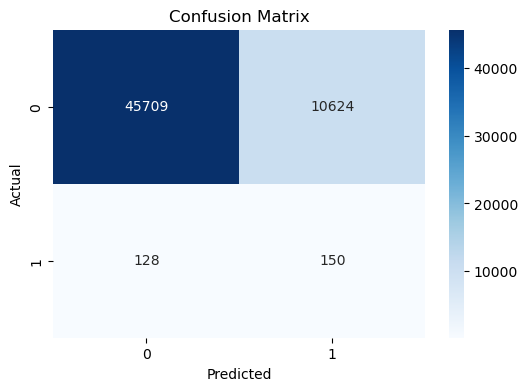

In [968]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [970]:
analysis = test_data.copy()
analysis['prediction'] = y_pred

In [818]:
derates_2019 = joined_ns[(joined_ns['spn'] == 5246) & (joined_ns['EventTimeStamp'] > '12-31-2018') & (joined_ns['active'] == True)]
derates_2019['derate_gap'] = derates_2019.sort_values(by=['EquipmentID', 'EventTimeStamp']).groupby('EquipmentID')['EventTimeStamp'].diff()
gap = pd.to_timedelta("24 hours")
confirmed_derates = derates_2019[(derates_2019.derate_gap.isnull()) | (derates_2019['derate_gap'] > gap)]
confirmed_derates

C:\Users\Maria\AppData\Local\Temp\ipykernel_36188\2109607501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  derates_2019['derate_gap'] = derates_2019.sort_values(by=['EquipmentID', 'EventTimeStamp']).groupby('EquipmentID')['EventTimeStamp'].diff()


,RecordID,EventTimeStamp,spn,fmi,active,EquipmentID,Latitude,Longitude,BarometricPressure,DistanceLtd,...,FuelRate,FuelTemperature,IntakeManifoldTemperature,LampStatus,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,derate_window,derate_gap
1062716,1105551,2019-01-13 21:21:37,5246,0,True,1698,34.698842,-81.938148,14.4275,529439.200000,...,0.237756,NaN,111.2,22527,0.000000,NaN,100.0,0.00,True,NaT
1079449,1124149,2019-02-20 19:21:49,5246,0,True,1739,41.147453,-73.254768,14.7900,594147.400000,...,0.818936,NaN,125.6,22527,0.000000,NaN,100.0,0.29,True,NaT
1069408,1113161,2019-01-29 22:35:39,5246,0,True,1758,30.478379,-90.460740,14.7900,478788.500000,...,0.594389,NaN,129.2,22527,0.000000,NaN,100.0,0.29,True,NaT
1070494,1114247,2019-01-31 21:23:21,5246,0,True,1758,35.137592,-90.487824,14.7175,479759.600000,...,0.501928,NaN,118.4,22527,0.000000,NaN,100.0,0.29,True,1 days 22:47:42
1072265,1116018,2019-02-05 19:59:02,5246,0,True,1758,39.725555,-86.220231,14.2825,481191.000000,...,0.581180,NaN,125.6,22527,0.000000,NaN,100.0,0.29,True,4 days 17:16:14
1093557,1141167,2019-03-26 07:37:57,5246,0,True,1768,36.013148,-83.532175,14.2100,570321.900000,...,0.000000,NaN,100.4,6143,0.000000,NaN,100.0,0.00,True,NaT
1115042,1164538,2019-05-29 19:41:57,5246,0,True,1797,32.805740,-96.886481,14.2825,412939.900000,...,0.818936,NaN,111.2,22527,0.000000,NaN,100.0,0.00,True,NaT
1079428,1124128,2019-02-20 18:24:28,5246,0,True,1811,36.797222,-87.392824,14.2825,405283.600000,...,0.000000,NaN,86.0,22527,0.000000,NaN,100.0,0.00,True,NaT
1080179,1124879,2019-02-22 07:10:21,5246,0,True,1818,34.537870,-86.910324,14.4275,410551.100000,...,0.554763,NaN,131.0,22527,0.000000,NaN,100.0,0.29,True,NaT
1127506,1178926,2019-07-14 05:02:48,5246,0,True,1818,35.871990,-84.322685,14.2825,410973.300000,...,1.452951,NaN,125.6,22527,2.873842,NaN,100.0,1.16,True,141 days 21:52:27


In [984]:
tp_analysis_temp = analysis[(analysis['derate'] == 1.0) & (analysis['prediction'] == 1.0)]
tp_analysis_temp = tp_analysis_temp[['EventTimeStamp', 'spn', 'EquipmentID', 'derate_window', 'derate', 'prediction']]

target_spn = 5246

tp_analysis_temp = tp_analysis_temp.sort_values(by=["EquipmentID", "EventTimeStamp"]).copy()

# Create a Series containing only the timestamps of trigger events
trigger_timestamps_only = tp_analysis_temp["EventTimeStamp"].where(tp_analysis_temp["spn"] == target_spn)

# For each row, find the timestamp of the *next* trigger event within its group
# Group by EquipmentID and use backward fill (bfill)
# This fills NaT values with the next valid timestamp in the group
tp_analysis_temp["next_trigger_time"] = trigger_timestamps_only.groupby(
    tp_analysis_temp["EquipmentID"]
).bfill()

In [986]:
tp_analysis = tp_analysis_temp
tp_analysis['trigger_gap'] = tp_analysis['next_trigger_time'] - tp_analysis['EventTimeStamp']
trigger_gap = pd.to_timedelta("2 hours")
tp_analysis = tp_analysis[(tp_analysis['trigger_gap'] > trigger_gap)]
tp_analysis.drop_duplicates(subset=['next_trigger_time'], keep = 'first', inplace = True)
tp_analysis = tp_analysis[(tp_analysis['spn'] != 5246) & (tp_analysis.next_trigger_time.notnull())]
tp_analysis['derate_gap'] = tp_analysis.sort_values(by=['EquipmentID', 'EventTimeStamp']).groupby('EquipmentID')['EventTimeStamp'].diff()
gap = pd.to_timedelta("24 hours")
confirmed_derates_2019 = tp_analysis[(tp_analysis.derate_gap.isnull()) | (tp_analysis['derate_gap'] > gap)]
confirmed_derates_2019

C:\Users\Maria\AppData\Local\Temp\ipykernel_36188\3707003953.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp_analysis.drop_duplicates(subset=['next_trigger_time'], keep = 'first', inplace = True)


,EventTimeStamp,spn,EquipmentID,derate_window,derate,prediction,next_trigger_time,trigger_gap,derate_gap
1079166,2019-02-20 12:01:22,1569,1739,False,1,1,2019-02-20 19:21:49,0 days 07:20:27,NaT
1069275,2019-01-29 14:24:41,1569,1758,False,1,1,2019-02-01 02:42:48,2 days 12:18:07,NaT
1092899,2019-03-24 07:19:16,1569,1768,False,1,1,2019-03-26 07:37:57,2 days 00:18:41,NaT
1116874,2019-06-04 17:34:39,1569,1951,False,1,1,2019-06-05 10:09:31,0 days 16:34:52,NaT
1076440,2019-02-14 08:42:30,1569,1961,True,1,1,2019-02-14 13:46:15,0 days 05:03:45,NaT
1086931,2019-03-08 09:31:05,4096,1964,True,1,1,2019-03-08 13:48:13,0 days 04:17:08,NaT
1153935,2019-11-01 15:40:21,3364,2089,True,1,1,2019-11-01 18:07:51,0 days 02:27:30,NaT
1170641,2020-01-03 10:00:43,2791,302,False,1,1,2020-01-06 10:13:57,3 days 00:13:14,NaT
1172874,2020-01-13 02:38:29,609,302,False,1,1,2020-01-13 13:18:31,0 days 10:40:02,9 days 16:37:46


In [988]:
confirmed_derates_2019.shape

(9, 9)

In [880]:
tp_analysis = analysis[(analysis['derate'] == 1.0) & (analysis['prediction'] == 1.0)]
tp_analysis = tp_analysis[['EventTimeStamp', 'spn', 'EquipmentID', 'derate_window', 'derate', 'prediction']]
tp_analysis['derate_gap'] = tp_analysis.sort_values(by=['EquipmentID', 'EventTimeStamp']).groupby('EquipmentID')['EventTimeStamp'].diff()
gap = pd.to_timedelta("24 hours")
confirmed_derates_2019 = tp_analysis[(tp_analysis.derate_gap.isnull()) | (tp_analysis['derate_gap'] > gap)]
confirmed_derates_2019[confirmed_derates_2019['spn'] == 5246]

,EventTimeStamp,spn,EquipmentID,derate_window,derate,prediction,derate_gap
1124972,2019-07-04 15:21:22,5246,1858,True,1,1,NaT
1113519,2019-05-23 21:57:05,5246,1896,True,1,1,NaT


In [978]:
tp_analysis = analysis[(analysis['derate'] == 1.0) & (analysis['prediction'] == 1.0)]
tp_analysis = tp_analysis[['EventTimeStamp', 'spn', 'EquipmentID', 'derate_window', 'derate', 'prediction']]
tp_analysis = tp_analysis[tp_analysis['derate_window'] == False]
tp_analysis['derate_gap'] = tp_analysis.sort_values(by=['EquipmentID', 'EventTimeStamp']).groupby('EquipmentID')['EventTimeStamp'].diff()
gap = pd.to_timedelta("24 hours")
confirmed_derates_2019 = tp_analysis[(tp_analysis.derate_gap.isnull()) | (tp_analysis['derate_gap'] > gap)]
confirmed_derates_2019

,EventTimeStamp,spn,EquipmentID,derate_window,derate,prediction,derate_gap
1079166,2019-02-20 12:01:22,1569,1739,False,1,1,NaT
1069275,2019-01-29 14:24:41,1569,1758,False,1,1,NaT
1070204,2019-01-31 10:27:23,1569,1758,False,1,1,1 days 20:02:42
1072123,2019-02-05 13:01:47,1569,1758,False,1,1,5 days 02:34:24
1092899,2019-03-24 07:19:16,1569,1768,False,1,1,NaT
1078651,2019-02-19 14:35:25,1569,1818,False,1,1,NaT
1122463,2019-06-24 20:43:03,1569,1818,False,1,1,125 days 06:07:38
1131022,2019-07-27 09:54:16,1569,1818,False,1,1,32 days 13:11:13
1064792,2019-01-18 02:05:51,1569,1827,False,1,1,NaT
1081182,2019-02-24 12:55:09,3362,1828,False,1,1,NaT


In [980]:
confirmed_derates_2019.shape[0]

23

In [990]:
fp_analysis = analysis[(analysis['derate'] == 0.0) & (analysis['prediction'] == 1.0)]
fp_analysis = fp_analysis[['EventTimeStamp', 'spn', 'EquipmentID', 'derate_window', 'derate', 'prediction']]
fp_analysis['derate_gap'] = fp_analysis.sort_values(by=['EquipmentID', 'EventTimeStamp']).groupby('EquipmentID')['EventTimeStamp'].diff()
gap = pd.to_timedelta("24 hours")
fp_derates_2019 = fp_analysis[(fp_analysis.derate_gap.isnull()) | (fp_analysis['derate_gap'] > gap)]
fp_derates_2019

,EventTimeStamp,spn,EquipmentID,derate_window,derate,prediction,derate_gap
1086711,2019-03-07 16:48:19,1675,105338729,False,0,1,NaT
1087615,2019-03-10 06:43:07,1761,105338729,False,0,1,2 days 12:59:59
1093996,2019-03-27 08:10:52,111,105338729,False,0,1,17 days 01:27:45
1094665,2019-03-29 06:08:56,111,105338729,False,0,1,1 days 21:24:35
1101439,2019-04-17 07:28:55,111,105338729,False,0,1,19 days 01:19:59
...,...,...,...,...,...,...,...
1110480,2019-05-15 06:49:16,3362,309,False,0,1,11 days 15:14:24
1119956,2019-06-14 12:28:50,829,309,False,0,1,30 days 05:39:34
1130391,2019-07-24 12:09:01,829,309,False,0,1,39 days 23:40:11
1131863,2019-07-31 12:19:46,829,309,False,0,1,7 days 00:10:45


In [890]:
fp_derates_2019.shape

(4751, 7)

In [936]:
confirmed_derates_2019.shape[0] * 4000 - fp_derates_2019.shape[0] * 500

-3040500

In [896]:
vars = train_data.drop(columns = ['RecordID', 'EventTimeStamp', #'fmi', 
                                     'EquipmentID', 'derate_window',
                                     'derate', 'IsTestData']).columns
vars = vars.to_list()

In [898]:
pd.DataFrame({
    'variable': vars,
    'coef': lr_model.coef_[0]
}).sort_values('coef', ascending=False)

,variable,coef
15,FuelTemperature,0.499901
17,Speed,0.453152
1,fmi,0.298128
4,BarometricPressure,0.267153
14,FuelRate,0.215144
19,Throttle,0.117133
11,EngineTimeLtd,0.116325
2,Latitude,0.095039
3,Longitude,0.085976
13,FuelLtd,0.078666


trying again with different threshold

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 321, train_size = 0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, random_state = 321, train_size = 0.6/0.8)